In [1]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
from tqdm import tqdm
%matplotlib inline

In [2]:
n_bins = 20
t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV

bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

In [3]:
gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

In [4]:

columns = ['run_id', 'array_event_id', 'mc_alt', 'mc_az', 'mc_energy', 'az_prediction', 'alt_prediction', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

print(len(protons))
print(len(gammas))

7331014
970696


In [5]:
columns = ['run_id', 'array_event_id', 'gamma_prediction', 'gamma_energy_prediction', 'telescope_type_name']
gamma_tel_events = fact.io.read_data(gamma_input, key='telescope_events', columns=columns)


lst = gamma_tel_events[gamma_tel_events.telescope_type_name == 'LST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()
mst = gamma_tel_events[gamma_tel_events.telescope_type_name == 'MST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()
sst = gamma_tel_events[gamma_tel_events.telescope_type_name == 'SST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()

lst_gammas = gammas.merge(lst, left_on=['run_id', 'array_event_id'], right_index=True)
mst_gammas = gammas.merge(mst, left_on=['run_id', 'array_event_id'], right_index=True)
sst_gammas = gammas.merge(sst, left_on=['run_id', 'array_event_id'], right_index=True)

lst_gammas.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)
mst_gammas.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)
sst_gammas.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)

columns = ['run_id', 'array_event_id', 'gamma_prediction', 'gamma_energy_prediction', 'telescope_type_name']
proton_tel_events = fact.io.read_data(proton_input, key='telescope_events', columns=columns)

lst = proton_tel_events[proton_tel_events.telescope_type_name == 'LST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()
mst = proton_tel_events[proton_tel_events.telescope_type_name == 'MST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()
sst = proton_tel_events[proton_tel_events.telescope_type_name == 'SST'].groupby(['run_id', 'array_event_id'])[['gamma_prediction', 'gamma_energy_prediction']].mean()

lst_protons = protons.merge(lst, left_on=['run_id', 'array_event_id'], right_index=True)
mst_protons = protons.merge(mst, left_on=['run_id', 'array_event_id'], right_index=True)
sst_protons = protons.merge(sst, left_on=['run_id', 'array_event_id'], right_index=True)

lst_protons.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)
mst_protons.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)
sst_protons.rename(columns={'gamma_energy_prediction': 'gamma_energy_prediction_mean', 'gamma_prediction': 'gamma_prediction_mean'}, inplace=True)

In [6]:
print(len(lst_gammas))

485399


In [7]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

lst_gammas['theta'] = calculate_theta(lst_gammas)
lst_protons['theta'] = calculate_theta(lst_protons)

mst_gammas['theta'] = calculate_theta(mst_gammas)
mst_protons['theta'] = calculate_theta(mst_protons)

sst_gammas['theta'] = calculate_theta(sst_gammas)
sst_protons['theta'] = calculate_theta(sst_protons)

Text(0.5,0,'Energy / TeV')

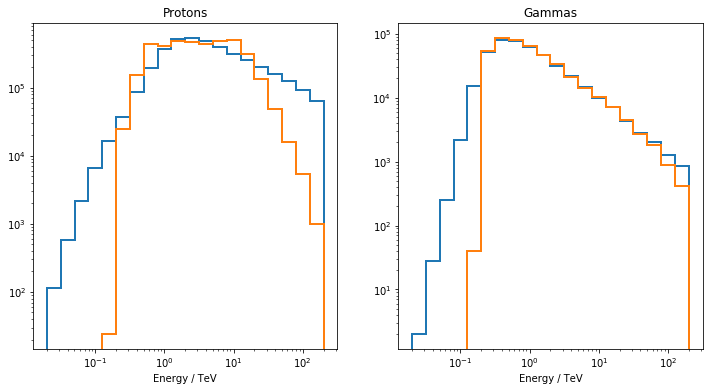

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(sst_protons.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax1.hist(sst_protons.gamma_energy_prediction_mean.dropna(), bins=bin_edges, histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Protons')
ax1.set_xlabel('Energy / TeV')

ax2.hist(sst_gammas.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax2.hist(sst_gammas.gamma_energy_prediction_mean.dropna(), bins=bin_edges, histtype='step', lw=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Gammas')
ax2.set_xlabel('Energy / TeV')

In [8]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()



def count_off_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    df = df.query('theta < 1.0')
    m = df.gamma_prediction_mean >= prediction_threshold
#     m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum() * theta2, m.sum() * theta2


def select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=False):
    
    column = 'mc_energy' if use_true_energy else 'gamma_energy_prediction_mean'
    m = ((signal[column] > e_low ) & (signal[column] < e_high ))
    s = signal[m]

    m = ((background[column] > e_low ) & (background[column] < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha=1, N=200): 
    
    right_bound = 100

    def target(scaling_factor, n_signal, n_background, alpha=1, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
#     print(t_background, n_background, '---------', t_signal, n_signal)
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    
    hs = []
    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background, alpha), bounds=(0, right_bound), method='bounded').x
            if np.allclose(result, right_bound):
                result = np.nan
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 5, 95))


# regions=slice(0.015, 0.02, 0.0025), thresholds=slice(0.8, 9, 0.05)
#regions=slice(0.0025, 0.07, 0.0025), thresholds=slice(0.3, 1, 0.05)
def find_best_cuts(signal, background, alpha, regions=slice(0.0025, 0.08, 0.01), thresholds=slice(0.4, 1, 0.05), method='simple'):
    
    def significance_target(cuts, signal, background, alpha):
        theta2, p_cut = cuts
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)

        if method == 'exact':
            n_background, t_background = count_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
        elif method == 'simple':
            n_background, t_background = count_off_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)

        if t_signal <= t_background * alpha + 10:
#             print('signal not large enough')
            return 0
        
        if n_signal*5 < n_background * 0.01:
#             print('sys problem')
            return 0
            
                
        n_on = n_signal + alpha*n_background
        n_off = n_background
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds], args=(signal, background, alpha), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, alpha=1, use_true_energy=False, method='simple'):
    relative_sensitivities = []

    for e_low, e_high in tqdm(zip(bin_edges[:-1], bin_edges[1:])):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=use_true_energy)
        
        theta2, cut = find_best_cuts(s, b, alpha=alpha, method=method)

        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)

        if method == 'simple':
            n_background, t_background = count_off_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
        elif method == 'exact':
            n_background, t_background = count_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
       
        rs = scaling_factor(n_signal, n_background, t_signal, t_background, alpha=alpha)
        relative_sensitivities.append(rs)
        
       
        
    m, l, h = np.array(relative_sensitivities).T
    d = {'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h}
    return pd.DataFrame(d)



In [9]:
def plot_sensitivity(rs, crab, bin_edges, bin_center, color='blue', **kwargs):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='', ecolor=color, **kwargs)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black',)

    
    path = '../resources/sensitivity_requirement_south_50.txt'
    df = pd.read_csv(path, delim_whitespace=True, names=['log_energy', 'sensitivity'], index_col=False,  engine='python')
    df['energy'] = 10**df.log_energy
    plt.plot(df.energy, df.sensitivity, color='gray')
    
    plt.plot(df.energy, df.sensitivity * 3, color='lightgray', linestyle='--')
    
    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


In [10]:
# rs_simple = calc_relative_sensitivity(gammas, protons, bin_edges, method='simple', alpha=0.2)
# rs_exact = calc_relative_sensitivity(gammas, protons, bin_edges, method='exact', alpha=0.2)
rs_lst = calc_relative_sensitivity(lst_gammas, lst_protons, bin_edges, method='simple', alpha=0.2)
rs_mst = calc_relative_sensitivity(mst_gammas, mst_protons, bin_edges, method='simple', alpha=0.2)
rs_sst = calc_relative_sensitivity(sst_gammas, sst_protons, bin_edges, method='simple', alpha=0.2)

0it [00:00, ?it/s]

[0.0625 0.9   ]


1it [00:02,  2.67s/it]

[0.0425 0.9   ]


2it [00:08,  4.43s/it]

[0.0325 0.9   ]


3it [00:15,  5.14s/it]

[0.0225 0.9   ]


4it [00:18,  4.52s/it]

[0.0225 0.9   ]


5it [00:20,  4.06s/it]

[0.0125 0.85  ]


6it [00:22,  3.75s/it]

[0.0125 0.85  ]


7it [00:24,  3.52s/it]

[0.0125 0.8   ]


8it [00:26,  3.33s/it]

[0.0125 0.8   ]


9it [00:28,  3.16s/it]

[0.0025 0.7   ]


10it [00:29,  3.00s/it]

[0.0025 0.7   ]


11it [00:31,  2.88s/it]

[0.0025 0.75  ]


12it [00:33,  2.76s/it]

[0.0025 0.7   ]


13it [00:34,  2.64s/it]

[0.0025 0.7   ]


14it [00:35,  2.53s/it]

[0.0025 0.7   ]


16it [00:37,  2.32s/it]

[0.0025 0.7   ]
[0.0025 0.6   ]


18it [00:39,  2.21s/it]

[0.0025 0.6   ]


19it [00:40,  2.13s/it]

[0.0025 0.8   ]


20it [00:41,  2.06s/it]
0it [00:00, ?it/s]

[0.0025 0.85  ]
[0.0025 0.4   ]


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
1it [00:02,  2.28s/it]

[0.0425 0.9   ]


2it [00:04,  2.34s/it]

[0.0325 0.8   ]


3it [00:11,  3.80s/it]

[0.0225 0.85  ]


4it [00:19,  4.86s/it]

[0.0225 0.85  ]


5it [00:26,  5.24s/it]

[0.0225 0.85  ]


6it [00:33,  5.52s/it]

[0.0225 0.8   ]


7it [00:39,  5.71s/it]

[0.0125 0.75  ]


8it [00:44,  5.59s/it]

[0.0125 0.75  ]


9it [00:50,  5.58s/it]

[0.0125 0.7   ]


10it [00:55,  5.55s/it]

[0.0125 0.75  ]


11it [00:57,  5.26s/it]

[0.0125 0.7   ]


12it [01:00,  5.01s/it]

[0.0125 0.75  ]


13it [01:02,  4.78s/it]

[0.0025 0.7   ]


14it [01:03,  4.56s/it]

[0.0025 0.7   ]


15it [01:05,  4.34s/it]

[0.0025 0.7   ]


17it [01:07,  3.96s/it]

[0.0025 0.7   ]


18it [01:08,  3.80s/it]

[0.0025 0.7   ]


19it [01:09,  3.65s/it]

[0.0025 0.65  ]


20it [01:10,  3.52s/it]
0it [00:00, ?it/s]

[0.0025 0.75  ]
[0.0025 0.4   ]


1it [00:02,  2.76s/it]

[0.0025 0.4   ]


2it [00:04,  2.30s/it]

[0.0025 0.4   ]


3it [00:06,  2.12s/it]

[0.0025 0.4   ]


4it [00:08,  2.09s/it]

[0.0525 0.5   ]


5it [00:09,  1.91s/it]

[0.0225 0.65  ]


6it [00:11,  1.98s/it]

[0.0125 0.8   ]


7it [00:14,  2.10s/it]

[0.0125 0.9   ]


8it [00:20,  2.60s/it]

[0.0125 0.85  ]


9it [00:26,  2.95s/it]

[0.0125 0.8   ]


10it [00:32,  3.28s/it]

[0.0125 0.7   ]


11it [00:37,  3.45s/it]

[0.0125 0.7   ]


12it [00:42,  3.58s/it]

[0.0125 0.7   ]


13it [00:47,  3.69s/it]

[0.0125 0.7   ]


14it [00:52,  3.78s/it]

[0.0125 0.7   ]


15it [00:57,  3.81s/it]

[0.0125 0.75  ]


16it [00:58,  3.68s/it]

[0.0125 0.7   ]


18it [01:01,  3.44s/it]

[0.0125 0.7   ]


19it [01:02,  3.31s/it]

[0.0125 0.7   ]


20it [01:03,  3.19s/it]

[0.0025 0.7   ]


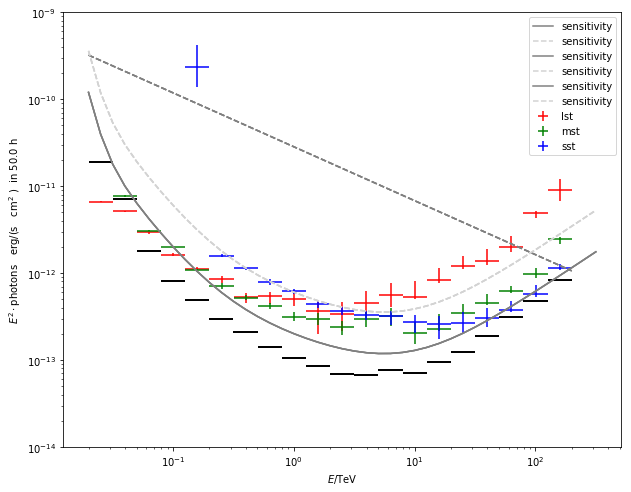

In [11]:
plt.figure(figsize=(10, 8))

# plot_sensitivity(rs_smooth, crab, bin_edges, bin_center, color='blue')

# plot_sensitivity(rs_simple, crab, bin_edges, bin_center, color='crimson', label='0.2')
plot_sensitivity(rs_lst, crab, bin_edges, bin_center, color='red', label='lst')
plot_sensitivity(rs_mst, crab, bin_edges, bin_center, color='green', label='mst')
plot_sensitivity(rs_sst, crab, bin_edges, bin_center, color='blue', label='sst')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='blue', label='exact 0.2')

# plot_sensitivity(rs_interpolate, crab, bin_edges, bin_center, color='blue', label='interpolate')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='green', label='exact')
plt.legend()

# plot_sensitivity(rs_simple_02, crab, bin_edges, bin_center, color='blue')


# plot_sensitivity(rs_smooth_02, crab, bin_edges, bin_center, color='navy')